# Predicting Pet Insurance Claims - EDA

## 1 Introduction

### 1.1 Background
Whenever a pet insurance policy holder incurs veterinary expenses related to their enrolled pet, they can submit claims for reimbursement, and the insurance company reimburses eligible expenses. To price insurance products correctly, the insurance company needs to have a good idea of the amount their policy holders are likely to claim in the future. 

### 1.2 Project Goal
The goal of this project is to create a machine learning model to predict how much (in dollars) a given policy holder will claim for during the second year of their policy. 

### 1.3 Initial Questions for EDA
Below are a few initial questions to answer and areas of interest for the detailed data analysis.
* What is the distribution of our claims amounts by year?
* What patterns or relationships exist between 'Species' and amounts claimed?
* What patterns or relationships exist between 'Breed' and amounts claimed?
* Does EnrollPath factor in to claims amounts in a meaningful way or should it be dropped?
* Is there a connection between PetAge and number or amount of claims?

## 2 Setup

### 2.1 Imports

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

# import random

import matplotlib.pyplot as plt
# %matplotlib inline
import seaborn as sns
# sns.set_theme(style="whitegrid")

### 2.2 Data Load & Preview

In [2]:
# Read in the data file generated during data wrangling
df = pd.read_csv('../data/merged_pets.csv')

# Preview
df.head()

,PetId,Species,Breed,Premium,Deductible,EnrollPath,AgeYr1,YoungAge,MixedBreed,AmtClaimsYr1,AmtClaimsYr2,AvgClaimsYr1,AvgClaimsYr2,NumClaimsYr1,NumClaimsYr2,AmtClaimsTotal,AvgClaimsTotal,NumClaimsTotal
0,0,Dog,Schnauzer Standard,84.54,200,Web,3,0,0,0.00,1242.00,0.000000,621.000,0,2,1242.00,621.000000,2
1,1,Dog,Yorkiepoo,50.33,500,Phone,0,0,0,0.00,0.00,0.000000,0.000,0,0,0.00,0.000000,0
2,2,Dog,Mixed Breed Medium,74.00,500,Phone,0,0,1,640.63,1187.68,213.543333,237.536,3,5,1828.31,451.079333,8
3,3,Dog,Labrador Retriever,57.54,500,Phone,0,0,0,0.00,0.00,0.000000,0.000,0,0,0.00,0.000000,0
4,4,Dog,French Bulldog,60.69,700,Web,0,0,0,7212.25,168.75,801.361111,168.750,9,1,7381.00,970.111111,10


## 3 Data Analysis


### 3.1 What is the count of pets per species?

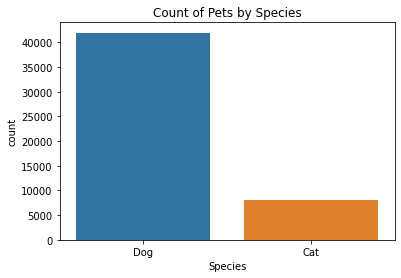

In [4]:
# Plot a count of each species
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.countplot(x='Species', data=df).set(title="Count of Pets by Species")
plt.show()

As observed above, we have approximately 50,000 pets in our data, roughly 85% of which are dogs. The remaining 15% are cats, so that keeps things fairly simple as we only have two breeds to compare. 

Why do we see such a big discrepency in the number of dogs vs. the number of cats?

It could mean that dogs are a more popular option for a pet, or it could mean that dogs are more expensive to keep healthy and insurance is needed. If that's the case, we should see dogs having higher premiums and/or higher deductibles. Let's plot the two and take a look at how the breeds stack up.

### 3.2 Do dog owners pay higher premiums or have higher deductibles than cat owners?

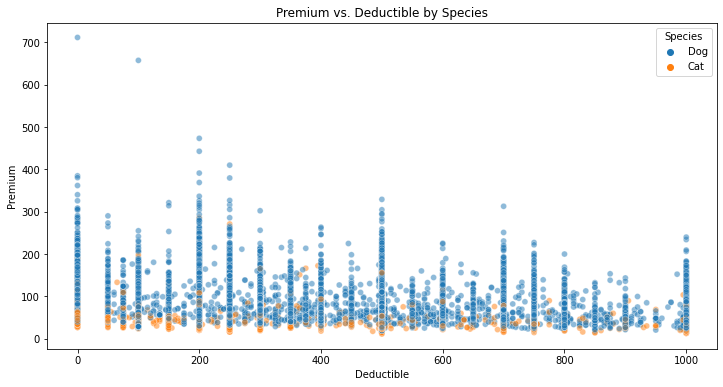

In [5]:
# Create a scatter plot showing premiums and deductibles by species
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.scatterplot(x='Deductible', y='Premium', data=df, hue='Species', 
               alpha=0.5).set(title="Premium vs. Deductible by Species")
plt.show()

It does look like dog owners pay higher premiums in general as we see cats tend to be grouped at the lower end of the premium range for each deductible. Let's try breaking these up to see if we get a better look.

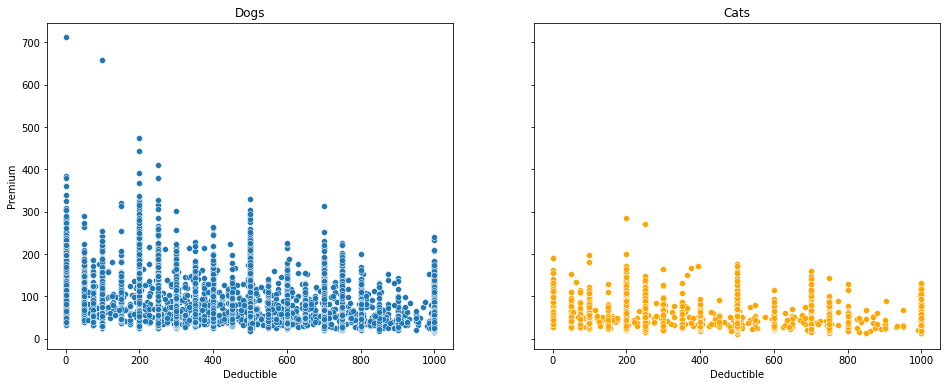

In [6]:
# Create news dfs per species
cats = df[df.Species == 'Cat'].copy()
dogs = df[df.Species == 'Dog'].copy()

# Create scatter plots showing premiums and deductibles by species
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
sns.scatterplot(x='Deductible', y='Premium', data=dogs, ax=ax1).set(title="Dogs")
sns.scatterplot(x='Deductible', y='Premium', data=cats, ax=ax2, color='orange').set(title="Cats")
plt.show()

For both species, we see clusters at the bottom of the premium range. It does look like dogs tend to have more variance and a higher upper range at just about every deductible level.

One interesting observation is that premiums don't appear to go down as deductibles go up. This seems counterintuitive and we should spend more time investigating later on. 

Before we move on, let's take one last look and see if age factors into the premium and deductible data by setting the size of our circles based on the age in year 1.

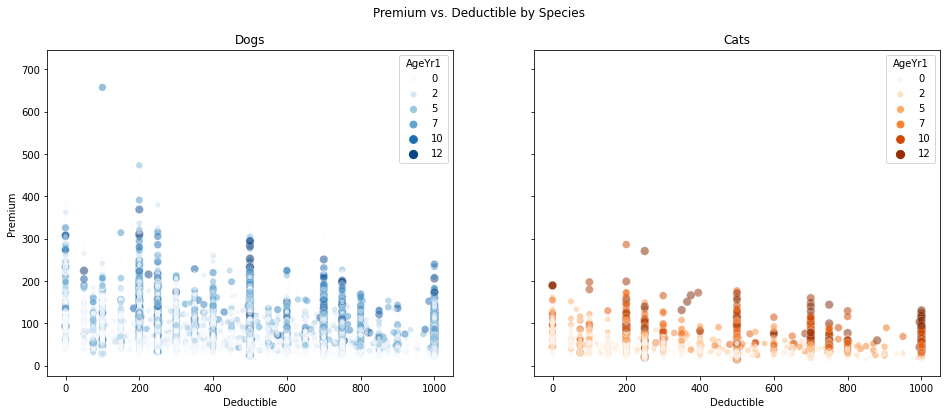

In [7]:
#TODO - Decide whether or not to keep this
# Create scatter plots showing premiums and deductibles by species
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
sns.scatterplot(x='Deductible', y='Premium', data=dogs, hue="AgeYr1", size="AgeYr1", palette="Blues",
                ax=ax1, alpha=0.5).set(title="Dogs")

sns.scatterplot(x='Deductible', y='Premium', data=cats, hue="AgeYr1", size="AgeYr1", palette="Oranges",
                ax=ax2, alpha=0.5).set(title="Cats")
plt.suptitle("Premium vs. Deductible by Species")
plt.show()

No trends stand out and it seems age doesn't factor in much to premium and deductible amounts. Perhaps Breed plays a factor and we can look into this when we get into a deeper analysis on breed.

Next, let's take a look at enroll path to determine if this matters at all for our analysis.

### 3.3 Does enroll path tell us anything about pet claims?
Intuitively, it's probably safe to say no. But it could be the case that enroll path tells us something about the pet owners that translates into more or fewer claims. Let's start by looking at a count of pets in each category.

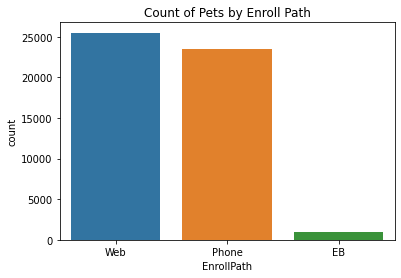

In [8]:
# Plot a count of pets in each enroll path
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.countplot(x='EnrollPath', data=df).set(title="Count of Pets by Enroll Path")
plt.show()

It looks like we have 3 possibilities, Web, Phone and EB. It's unclear what "EB" stands for, but luckliy that is a pretty small percentage of our data. The majoirity of pets were enrolled by either Web or Phone.

Since claims amounts are the focus of this project, let's see if there is any noticeable difference in number or amount of claims related to enroll path. If not, it's probably safe for us to drop this column.

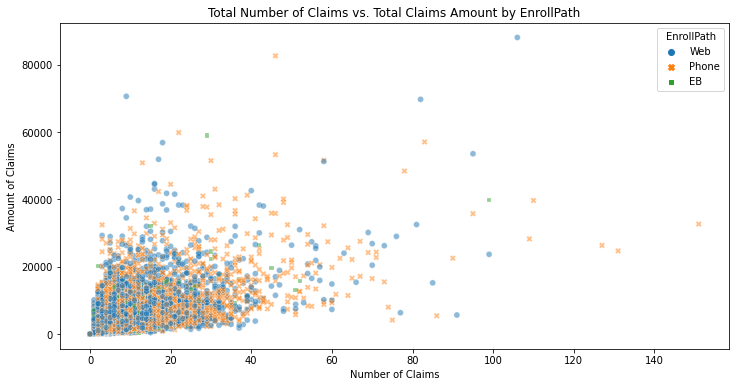

In [9]:
# Create a scatter plot showing number and amount of claims by enroll path
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.scatterplot(x="NumClaimsTotal", y="AmtClaimsTotal", data=df, hue="EnrollPath", style="EnrollPath", 
               alpha=0.5).set(title="Total Number of Claims vs. Total Claims Amount by EnrollPath")
plt.xlabel("Number of Claims")
plt.ylabel("Amount of Claims")
plt.show()

It's difficult to draw any meaningful conclusions from the scatter plot and it looks like the distribution of claims (Number and Amount) may be similar for each enroll path. Let's take a look at our distribution for each enroll path before we make the decision about dropping it.

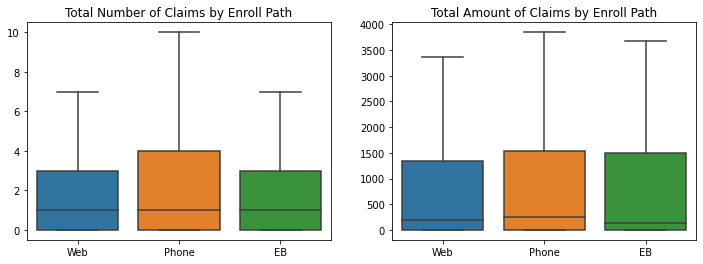

In [10]:
# Create box plots showing distribution of number and amount of claims by enroll path
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(x="EnrollPath", y="NumClaimsTotal", data=df, ax=ax1,
            sym="").set(title = "Total Number of Claims by Enroll Path", xlabel="", ylabel="")
sns.boxplot(x="EnrollPath", y="AmtClaimsTotal", data=df, ax=ax2,
            sym="").set(title = "Total Amount of Claims by Enroll Path", xlabel="", ylabel="")
plt.show()

While we do see some slight variation in the plots above, it doesn't seem to be significant enough to draw the conclusion that enroll path has an affect on number or amount of claims. Given this, we'll drop that column and move on.

In [11]:
# Drop EnrollPath
df = df.drop(columns=["EnrollPath"])

### 3.4 Are dogs more expensive that cats?
Earlier, we observed that dog owners *generally* pay higher insurance premiums than cat owners. Intuitively, that should mean that dog owners have higher claims amounts than cat owners. Let's take a look.

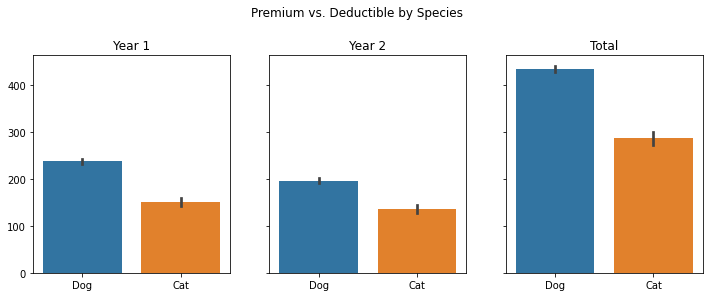

In [14]:
# Plot average total of claims amounts by year and species
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
sns.barplot(x="Species", y="AvgClaimsYr1", data=df, ax=ax1).set(title="Year 1", xlabel="", ylabel="")
sns.barplot(x="Species", y="AvgClaimsYr2", data=df, ax=ax2).set(title="Year 2", xlabel="", ylabel="")
sns.barplot(x="Species", y="AvgClaimsTotal", data=df, ax=ax3).set(title="Total", xlabel="", ylabel="")
# plt.suptitle("Average Total Claims by Year")
plt.suptitle("Premium vs. Deductible by Species", y=1.05)
plt.show()

Based on the above, it seems like we can draw the conclusion that on average, dogs are more expensive that cats when it comes to average claims. This could be due to a small number of dogs with high claims or it could be an overall trend. Let's take a look at the relationship between number of claims and amount of claims to see how this relationship differs by species.

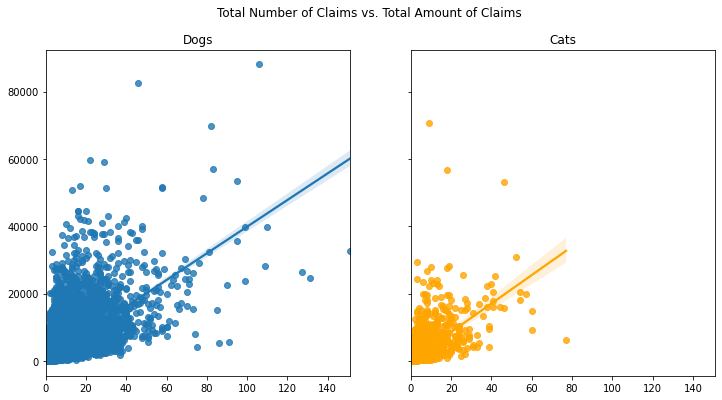

In [48]:
# Create a regression plot for Total Number of Claims vs. Total Amount of Claims by Species
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True, sharex=True)
sns.regplot(x="NumClaimsTotal", y="AmtClaimsTotal", data=dogs,
            ax=ax1).set(title="Dogs", xlabel="", ylabel="")
sns.regplot(x="NumClaimsTotal", y="AmtClaimsTotal", data=cats, color="orange",
            ax=ax2).set(title="Cats", xlabel="", ylabel="")
plt.suptitle("Total Number of Claims vs. Total Amount of Claims")
plt.show()

Based on the regression plot above, it doesn't appear that there is much difference between cats and dogs in terms of the relationship between number of claims and total claims. We do see that generally speaking, as the number of claims goes up, so does the total amount of claims. This feels like a pretty obvious conclusion, but good to confirm it.

There are definitely more dogs with higher numbers of claims and with higher claims amounts, but this seems to be due mostly to the fact that we have so much more data for dogs. Before moving on, let's take one last look at the distributions of total claims amounts by species.

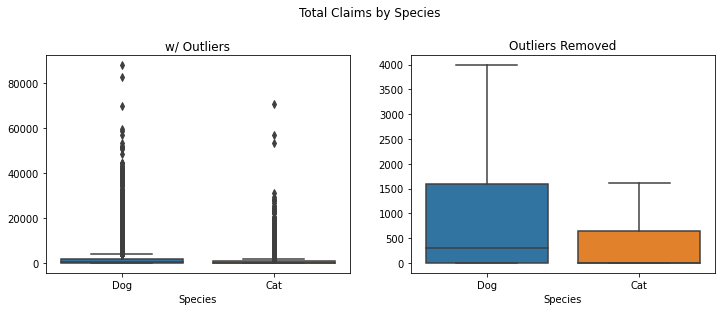

In [49]:
# Calculate total claims amount per pet
amt_claims_total = df["AmtClaimsYr1"] + df["AmtClaimsYr2"]

# Create boxplot showing the distribution of claims totals by species
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(x="Species", y=amt_claims_total, data=df, ax=ax1).set(title = "w/ Outliers")
sns.boxplot(x="Species", y=amt_claims_total, data=df, ax=ax2, sym="").set(title = "Outliers Removed")
plt.suptitle("Total Claims by Species", y=1.05)
plt.show()

The above plots tells a pretty compelling story. After removing outliers, the entire distribution of claims totals for cats fits within the first 75% of the distribution for dogs. And the remaining 25% of claims totals for dogs covers a spread nearly twice as big as the entire range for cats.

**Conclusions about species**
* Species does appear to be a factor in claims amounts and we should consider accounting for this in the  predictive model
* Number and amount of claims is highly variable regardless of species


### 3.5 Does Age Factor into Claims?
This also seems obvious, but let's take a look at how the claims totals break down by Species and Age.

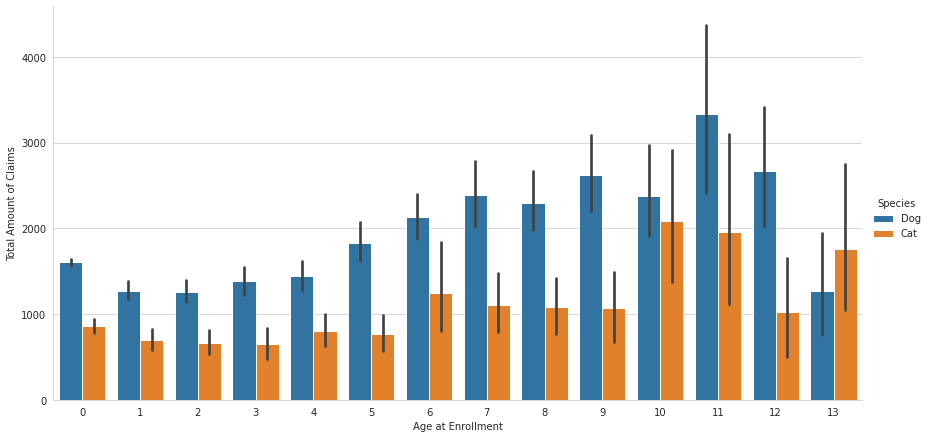

In [62]:
# Create a nested barplot showing total claims by Age and Species
sns.catplot(kind="bar", x="AgeYr1", y="AmtClaimsTotal", data=df, hue="Species", aspect=2,
                height=6).set(title="", xlabel="Age at Enrollment", ylabel="Total Amount of Claims");

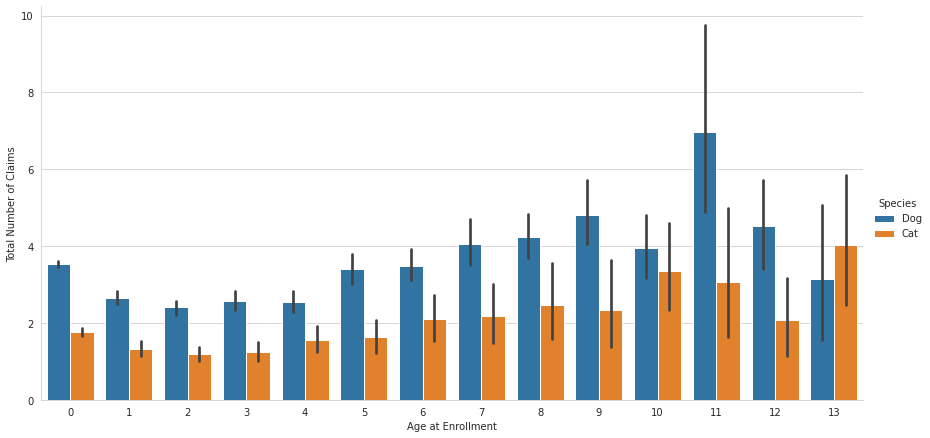

In [63]:
# Create a nested barplot showing total claims by Age and Species
sns.catplot(kind="bar", x="AgeYr1", y="NumClaimsTotal", data=df, hue="Species", aspect=2,
                height=6).set(title="", xlabel="Age at Enrollment", ylabel="Total Number of Claims");

This is an interesting perspective. The amount and number of claims for dogs exceed those for cats by a considerable margin at every age along the spectrum with the exception of the oldest age in our dataset (13). In addition, the confidence interval on the claims data is generally increasing in proportion to pet age. Intuitively this makes sense given that we would expect to see a greater variance in healthcare costs as pets age.

# Start Here

### 3.5 What is the Distribution of Claims?
In the data wrangling notebook, we looked at the claims data with each claim as its own data point. We observed some very high claims amounts (> \$10,000), but we didn't do any deeper analysis. As a next step, let's view the distribution of claims for year 1 and year 2, respectively.

**BREED:**
* Does it make sense to look at the proportion of a breed with high claims and see if any of the breeds stand out?
* Should I only pay attention to this is the breeds in question have a count of pets higher than some significant number (e.g., 30)?

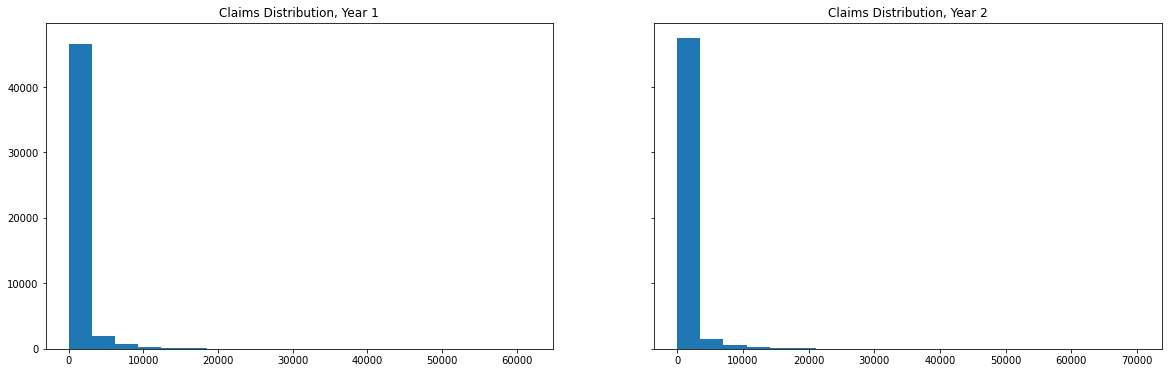

In [51]:
# Create histograms showing the distribution of claims for years 1 and 2 
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(20,6))
ax1.hist(df.AmtClaimsYr1, bins=20)
ax1.set_title("Claims Distribution, Year 1")
ax2.hist(df.AmtClaimsYr2, bins=20)
ax2.set_title("Claims Distribution, Year 2")
plt.show()

Obervations - lots of \\$0 claims

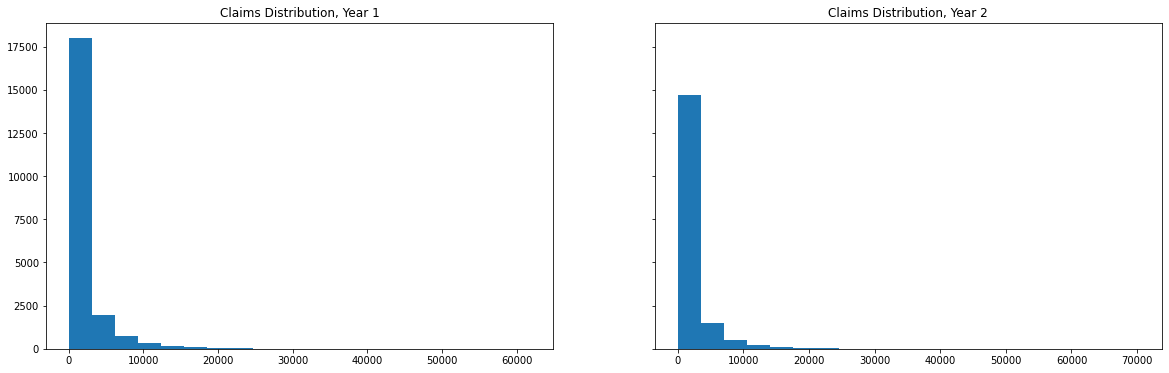

In [52]:
# Filter out $0 Claims Amounts
yr1_greater_0 = df[df.AmtClaimsYr1 > 0]['AmtClaimsYr1'] 
yr2_greater_0 = df[df.AmtClaimsYr2 > 0]['AmtClaimsYr2'] 

# Create histograms showing the distribution of claims for years 1 and 2 
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(20,6))
ax1.hist(yr1_greater_0, bins=20)
ax1.set_title("Claims Distribution, Year 1")
ax2.hist(yr2_greater_0, bins=20)
ax2.set_title("Claims Distribution, Year 2")
plt.show()

#### 4.1.1 Initial observations
Some initial observations based on the breakdown above:
1. On average, Dogs have higher premiums and higher deductibles
2. Dogs tend to be enrolled at a younger age by nearly a year on average
3. The averages for claims data (i.e., number of claims, average claim amount, and total claims amount) is higher for dogs across the board and in some cases, is as much as 2x higher than for cats.
4. While not a difference between cats and dogs, it's interesting to see that the median value for all claims categories is 0. This last point will almost certainly factor in as we move forward with analysis.

### 4.2 Claims differences between species
Since the focus of this study is on claims amounts, we'll focus on claims-related categories for now. The difference in the average claims amounts between cats and dogs in year one appears to be significant with dogs (\\$867) at more than 2x higher than cats (\\$433). And in year 2, the average for dogs (\\$739) is not quite 2x the average for cats (\\$445), but it's close.

Based on this, we may need to factor this in to our predictive model later on as it appears that a single model may not work well across the two species.

Before we make the final decision, let's plot the data for a better look.

#### 4.2.1 Disstribution of claims by species

## 5 Breed - Does Breed Factor in to Claims Amounts?

TBD - write up intro for this section with initial list of questions

### 5.1 Cat breeds
TBD - write up if needed

Since we only have ~35 total cat breeds, we can take a quick look at a rollup of claims data for all breeds to help guide next steps.

In [ ]:
# Create cats dataframe
cats = df[df.Species == 'Cat'].copy()

# Group cats by breed and aggregate claims data columns
cats_by_breed = cats.groupby('Breed').agg({'PetId': ['count'],
                                           'NumClaimsYr1':['mean'],
                                           'NumClaimsYr2':['mean'],
                                           'AmtClaimsYr1':['mean', 'median', 'min', 'max'], 
                                           'AmtClaimsYr2':['mean', 'median', 'min', 'max']}
                                         )
# View result
cats_by_breed

#### 5.1.1 Initial observations on cat breeds
TBD
* The number of cats for each breed covers a wide range, from 1 pet for certain breeds to 3511 for the most common breed. 
* Some breeds with a low count have 0 claims (e.g., American Wirehair and Chartreux), while others have very high claims (e.g., Selkirk Rex). 
* The most common values for median and minimum claims amounts is \\$0. This matches up with what we observed earlier on in the analysis and will likely factor in to the final predictions.
* Others??

TODO for conclusions - will need to pick a count that is reasonable and then group breeds below that count into an "Other" category.

In [ ]:
# Preview number of cat breeds with a count of pets greater than 30
cats_by_breed[cats_by_breed['PetId']['count'] >= 30]['PetId']['count'].sort_values(ascending=False)

In [ ]:
# Preview full result
cats_by_breed[cats_by_breed['PetId']['count'] >= 30].sort_values([('AmtClaimsYr2', 'mean')], ascending=False)

In [ ]:
# Preserve list of Breeds with count greater equal to 30
cat_breeds = cats_by_breed[cats_by_breed['PetId']['count'] >= 30].index.to_list()

# cats_by_breed.reset_index(inplace=True)

# Group breeds as 'Other' if count less than 30


In [ ]:
# x = cats_by_breed[cats_by_breed['PetId']['count'] >= 30].index
# y1 = cats_by_breed[cats_by_breed['PetId']['count'] >= 30][('AmtClaimsYr1', 'mean')]
# y2 = cats_by_breed[cats_by_breed['PetId']['count'] >= 30][('AmtClaimsYr2', 'mean')]

plt.figure(figsize=(10,6))
# _ = plt.barh([y1,y2], stacked=True, width=1.0)
cats_by_breed[cats_by_breed['PetId']['count'] >= 30][[('AmtClaimsYr1', 'mean'),('AmtClaimsYr2', 'mean')]].plot(kind='barh', stacked=True)

plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Review Distributions of all numeric columns
df.hist(figsize=(15,10))
_ = plt.subplots_adjust(hspace=0.5)
plt.show()

In [ ]:
# Preview full result
cats_by_breed[cats_by_breed['PetId']['count'] < 30].sort_values([('AmtClaimsYr2', 'mean')], ascending=False)

In [ ]:
###########
# TODO
##########
# View distribution of average claims by cat breed (below seems like it would work for dogs as well)
## Maybe a scatter plot - each breed is a point plotted based on avg total num claims and avg total amount claims 
## Scatter plot circle size based on count of breed

# Remove outlier claims amounts
# Group cat breeds with fewer than 20 or 30 representative cats (unless it seems there is a significant difference maybe?? how to do this?)


In [ ]:
# breed_counts = cats_by_breed['NumClaimsTotal', 'count']
# breed_num_claims = cats_by_breed['NumClaimsTotal', 'mean']
# breed_amt_claims = cats_by_breed['AmtClaimsTotal', 'mean']

# plt.figure(figsize=(10,6))
# _ = sns.scatterplot(data=cats_by_breed, x=breed_num_claims, y=breed_amt_claims, 
#                     size=breed_counts, sizes=(20, 200), legend=False)
# plt.show()

In [ ]:
# cats_by_breed = cats_by_breed[cats_by_breed['AmtClaimsTotal', 'mean'] < 2000]

In [ ]:
# breed_counts = cats_by_breed['NumClaimsTotal', 'count']
# breed_num_claims = cats_by_breed['NumClaimsTotal', 'mean']
# breed_amt_claims = cats_by_breed['AmtClaimsTotal', 'mean']

# plt.figure(figsize=(10,6))
# _ = sns.scatterplot(data=cats_by_breed, x=breed_num_claims, y=breed_amt_claims, 
#                     hue=breed_counts, size=breed_counts, sizes=(20, 200), legend=True)

# plt.xlabel('Avg Total Number of Claims')
# plt.ylabel('Avg Total Amount of Claims')
# plt.title('Average Claims by Breed')
# # _._legend.set_title('Count of Breed')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5, title="Count of Breed")

# plt.show()

## Consider plotting the claims in year 1 and 2 after removing the outlier data to get a better distribution.

## Correlation between Yr2 claims and other features

In [ ]:
cats = df[df.Species == 'Cat'].copy()
dogs = df[df.Species == 'Dog'].copy()

In [ ]:
cats_corr = cats.corr()
dogs_corr = dogs.corr()

In [ ]:
cats_corr

Total and average claims are highly correlated with yr1 and yr2 totals and averages, respectively. This makes sense. Some additional areas for analysis include:

1. Investigate to see if high yr1 claims tend to lead to high yr2 claims, or if there is any connection. (correlation is only 0.177)

2. 

In [ ]:
plt.figure(figsize=(10,6))
_ = sns.heatmap(cats_corr)
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
_ = sns.heatmap(dogs_corr)
plt.show()

## Are claims in year 1 a good predictor of claims in year 2? 

In [ ]:
sns.scatterplot(x="AmtClaimsYr1", y="AmtClaimsYr2", data=df)
plt.show()

In [ ]:
# Linear regression

# Create arrays of values
AmtClaimsYr1 = df.AmtClaimsYr1.values
AmtClaimsYr2 = df.AmtClaimsYr2.values

# Create the scatterplot
plt.figure(figsize=(10,6))
# _ = plt.plot(AmtClaimsYr1, AmtClaimsYr2, marker='.', linestyle='none')
sns.scatterplot(x="AmtClaimsYr1", y="AmtClaimsYr2", data=df)
plt.margins(0.02)
_ = plt.xlabel('Claims Total in Year 1')
_ = plt.ylabel('Claims Total in Year 2')

# Perform a linear regression using np.polyfit(): a, b
a, b = np.polyfit(AmtClaimsYr1, AmtClaimsYr2, 1)

# # Print the results to the screen
# print('slope =', a, 'Claims Total in Year 2 / Claims Total in Year 1')
# print('intercept =', b, 'Claims Total in Year 2')

# Make theoretical line to plot
x = np.array([0, 70000])
y = a * x + b

# Add regression line to your plot
_ = plt.plot(x, y, color='orange')

# Draw the plot
plt.show()

In [ ]:
######
# TODO - Consider doing a similar plot as above for yr1 vs total and year2 vs total? Or a facet grid of all features
######

## What percentage of pets have no claims at all? Claims in year 1 and in year 2? Claims in only one of the two years?

In [ ]:
# Calculate the percentages of pets with claims > $0 in 1 yr, 2 yrs and not at all 
no_claims = round(df[(df['AmtClaimsYr1'] == 0) & (df['AmtClaimsYr2'] == 0)].shape[0] / df.shape[0] * 100)
both_yr_claims = round(df[(df['AmtClaimsYr1'] > 0) & (df['AmtClaimsYr2'] > 0)].shape[0] / df.shape[0] * 100)
one_yr_claims = 100 - (no_claims + both_yr_claims)

# Print the result
print(str(no_claims) + "% of pets have no claims")
print(str(one_yr_claims) + "% of pets have claims in only one year")
print(str(both_yr_claims) + "% of pets have claims in both years")

## Is there a connection between the number of claims submitted in year 1 and year 2?

## Breed analysis

In [ ]:
# Groupby Breed column and aggregate the mean of the total claims amount
breed_claims = df.groupby(by=['Species', 'Breed']).AmtClaimsYr2.agg(['mean', 'count']).sort_values(by='mean',
                                                                                        ascending=False)
# Rename aggregate columns 
breed_claims.rename(columns={"mean": "AvgTotalClaims", "count": "BreedCount"}, inplace=True)

# Preview descriptive statistics 
breed_claims.describe()

In [ ]:
breed_claims.head(50)

## EnrollPath - Do people who enroll on the web submit more claims on average than those enrolling by phone?

Does enrollpath matter in terms of number of claims filed?
Look at median claims

In [ ]:
# Preview enroll path entries and value counts
df.EnrollPath.value_counts()

In [ ]:
# Group data by enrollpath
enrollpath = df.groupby(by='EnrollPath')

# Display aggregated statistics for total claims amount by enrollpath
enrollpath.NumClaimsYr2.agg(['mean', 'median', 'min', 'max'])

In [ ]:
# Display aggregated statistics for total claims amount by enrollpath
enrollpath.AmtClaimsYr2.agg(['mean', 'median', 'min', 'max'])

## How much does age play a roll in yr2 claims totals?
1. Look at average claims amount grouped by age in years
2. Scatterplot of AgeYr2 and AmtClaimsYr2 (maybe do this all up and also a facetgrid with a plot per year)
3. 

In [ ]:
# Aggregate mean claims data per year and total
yr1_claims = df.groupby(by='AgeYr1').AmtClaimsYr1.agg('mean')
yr2_claims = df.groupby(by='AgeYr1').AmtClaimsYr2.agg('mean')
# total_claims = df.groupby(by='AgeYr2').AmtClaimsTotal.agg('mean')

# Create plots and label
plt.figure(figsize=(10,6))
_ = plt.plot(yr1_claims, label='Year 1 Claims')
_ = plt.plot(yr2_claims, label='Year 2 Claims')
# _ = plt.plot(total_claims, label='Total Claims')

plt.xlabel('Pet Age in Years')
plt.ylabel('Dollars')

plt.legend()
plt.show()

# Sample code below

In [ ]:
# # Isolate rows with high premiums for additional review
# high_prems = pets[pets['Premium'] > 200]

# # Review date distribution
# plt.figure(figsize=(6, 4))
# plt.title('Distribution of High Premiums')
# plt.hist(high_prems.Premium, bins = 20)
# plt.show()

In [ ]:
# # Review the number of pets with high premiums by species
# high_prems.Species.value_counts()

In [ ]:
# # Plotting a histogram
# # Compute number of data points: n_data
# n_data = len(versicolor_petal_length)

# # Number of bins is the square root of number of data points: n_bins
# n_bins = np.sqrt(n_data)

# # Convert number of bins to integer: n_bins
# n_bins = int(n_bins)

# # Plot the histogram
# _ = plt.hist(versicolor_petal_length, bins=n_bins)

# # Label axes
# _ = plt.xlabel('petal length (cm)')
# _ = plt.ylabel('count')

# # Show histogram
# plt.show()

In [ ]:
# # Plotting a beeswarm plot
# # Create bee swarm plot with Seaborn's default settings
# _ = sns.swarmplot(x='species', y='petal length (cm)', data=df)

# # Label the axes
# _ = plt.xlabel('species')
# _ = plt.ylabel('petal length (cm)')

# # Show the plot
# plt.show()

In [ ]:
# # ECDF function
# def ecdf(data):
#     """Compute ECDF for a one-dimensional array of measurements."""
#     # Number of data points: n
#     n = len(data)

#     # x-data for the ECDF: x
#     x = np.sort(data)

#     # y-data for the ECDF: y
#     y = np.arange(1, n+1) / n

#     return x, y

In [ ]:
# # Compute and plot ECDF 

# # Compute ECDF for versicolor data: x_vers, y_vers
# x_vers, y_vers = ecdf(versicolor_petal_length)

# # Generate plot
# _ = plt.plot(x_vers, y_vers, marker='.', linestyle='none')

# # Label the axes
# _ = plt.xlabel('petal length (cm)')
# _ = plt.ylabel('ECDF')

# # Display the plot
# plt.show()

In [ ]:
# # Comparison of ECDFs

# # Compute ECDFs
# x_set, y_set = ecdf(setosa_petal_length)
# x_vers, y_vers = ecdf(versicolor_petal_length)
# x_virg, y_virg = ecdf(virginica_petal_length)

# # Plot all ECDFs on the same plot
# _ = plt.plot(x_set, y_set, marker='.', linestyle='none')
# _ = plt.plot(x_vers, y_vers, marker='.',linestyle='none')
# _ = plt.plot(x_virg, y_virg, marker='.',linestyle='none')

# # Annotate the plot
# plt.legend(('setosa', 'versicolor', 'virginica'), loc='lower right')
# _ = plt.xlabel('petal length (cm)')
# _ = plt.ylabel('ECDF')

# # Display the plot
# plt.show()

In [ ]:
# # Comparing percentiles to ECDFs

# # Compute percentiles

# # Specify array of percentiles: percentiles
# percentiles = np.array([2.5, 25,50,75, 97.5])

# # Compute percentiles: ptiles_vers
# ptiles_vers = np.percentile(versicolor_petal_length, percentiles)

# # Print the result
# print(ptiles_vers)

# # Plot the ECDF
# _ = plt.plot(x_vers, y_vers, '.')
# _ = plt.xlabel('petal length (cm)')
# _ = plt.ylabel('ECDF')

# # Overlay percentiles as red diamonds.
# _ = plt.plot(ptiles_vers, percentiles/100, marker='D', color='red',
#          linestyle='none')

# # Show the plot
# plt.show()

In [ ]:
# # Compare ditribution of feature with normal distribution

# # Compute mean and standard deviation: mu, sigma
# mu = np.mean(belmont_no_outliers)
# sigma = np.std(belmont_no_outliers)

# # Sample out of a normal distribution with this mu and sigma: samples
# samples = np.random.normal(mu, sigma, 10000)

# # Get the CDF of the samples and of the data
# x_theor, y_theor = ecdf(samples)
# x, y = ecdf(belmont_no_outliers)

# # Plot the CDFs and show the plot
# _ = plt.plot(x_theor, y_theor)
# _ = plt.plot(x, y, marker='.', linestyle='none')
# _ = plt.xlabel('Belmont winning time (sec.)')
# _ = plt.ylabel('CDF')
# plt.show()

In [ ]:
# # Linear regression

# # Plot the illiteracy rate versus fertility
# _ = plt.plot(illiteracy, fertility, marker='.', linestyle='none')
# plt.margins(0.02)
# _ = plt.xlabel('percent illiterate')
# _ = plt.ylabel('fertility')

# # Perform a linear regression using np.polyfit(): a, b
# a, b = np.polyfit(illiteracy, fertility, 1)

# # Print the results to the screen
# print('slope =', a, 'children per woman / percent illiterate')
# print('intercept =', b, 'children per woman')

# # Make theoretical line to plot
# x = np.array([0, 100])
# y = a * x + b

# # Add regression line to your plot
# _ = plt.plot(x, y)

# # Draw the plot
# plt.show()